In [1]:
!git clone https://github.com/0xpantera/UFM-AI-22.git
%cd UFM-AI-22
from install import *
install_requirements()

Cloning into 'UFM-AI-22'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 77 (delta 32), reused 30 (delta 7), pack-reused 0
Unpacking objects: 100% (77/77), done.
/content/UFM-AI-22
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
from utils import *
setup_lecture()

Using transformers v4.11.3
Using datasets v1.16.1


# Multilingual Named Entity Recognition

En resumen: reconocimiento de entidades con nombres pre definidos como organizaciones, nombres de personas, companias, localidades, codigos medicos, cantidades, valores monetarios, porcentajes, etc.

[Jim]Person bought 300 shares of [Acme Corp.]Organization in [2006]Time.

Al igual que BERT, estos modelos utilizan el _masked language modeling_ como objetivo de preentrenamiento, pero se entrenan conjuntamente en textos en más de cien idiomas. Al entrenarse previamente en corpus enormes en muchos idiomas, estos transformers multilingües permiten _zero-shot cross-lingual transfer_. Esto significa que un modelo que está entrenado en un idioma se puede aplicar a otros sin necesidad de entrenamiento adicional. Esto también hace que estos modelos sean muy adecuados para el _code-switching_, donde un hablante alterna entre dos o más idiomas o dialectos en el contexto de una sola conversación.

En este notebook vamos a explorar como un transformer llamado XLM-RoBERTa[1] puede ser ajustado para realizar NER a traves de varios lenguajes.

> _Zero-shot transfer_ o _zero-shot learning_ se refiere a la tarea de entrenar un modelo en un conjunto de etiquetas y luego evaluarlo en un conjunto diferente de etiquetas. En el contexto de los transformers, zero-shot learning también puede referirse a situaciones en las que un modelo de lenguaje como GPT-3 se evalúa en una tarea posterior en la que ni siquiera se ajustó.

[1] A. Conneau et al., [“Unsupervised Cross-Lingual Representation Learning at Scale”](https://arxiv.org/abs/1911.02116), (2019).

## El Dataset

Un subset del benchamrk Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME) llamado WikiANN o PAN-X[2]. Este dataset consiste en articulos de Wikipedia en varios lenguajes, incluyendo los cuatro lenguajes hablados en Suiza: Aleman (62.9%), Frances (22.9%), Italiano (8.4%), e Ingles (5.9%). Cada articulo esta anotado con `LOC` (location), `PER` (person), `ORG` (organization) en el [formato "inside-out beginning" (IOB2)](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)). En este formato, un prefijo `B-` indica el principio de una entidad y tokens consecutivos que pertenecen a la misma entidad tienen un prefijo `I-`. Un tag `O` indica que el token no percenece a ninguna entidad. Por ejemplo en la siguienta oracion:

> Jeff Dean is a computer scientist at Google in California

Seria etiquetada en el formato IOB2 asi:

Jeff[B-PER] Dean[I-PER] is[0] a[0] computer[0] scientist[0] at[0] Google[B-ORG] in[0] California[B-LOC]

Ahora cargemos el dataset. Vamos a tener que buscar que configuracion pasar a la funcion de `load_dataset()`. Cuando usemos un dataset con multiples dominios, podemos usar la funcion `get_dataset_config_names()` para buscar que subconjuntos estan disponibles:

[2] J. Hu et al., [“XTREME: A Massively Multilingual Multi-Task Benchmark for Evaluating Cross-Lingual Gener‐ alization”](https://arxiv.org/abs/2003.11080), (2020); X. Pan et al., “Cross-Lingual Name Tagging and Linking for 282 Languages,” Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics 1 (July 2017): 1946–1958, http:// dx.doi.org/10.18653/v1/P17-1178.

In [3]:
from datasets import get_dataset_config_names 
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

XTREME has 183 configurations


Hay bastantes configuraciones. Probemos filtrar buscando solo las configuraciones que empiezan con "PAN":

In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")] 
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

Ok, logramos identificar el syntax de los subconjuntos PAN-X: cada uno tiene un sufijo que parece ser un [codigo de lenguaje ISO 639-1](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes).

Esto significa que si queremos cargar el corpus en Aleman pasamos el codigo `de` al argumento `name` de la funcion:

In [5]:
from datasets import load_dataset 
load_dataset("xtreme", name="PAN-X.de")

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

Para hacer el corpus Suizo realistico, vamos a muestrear de los corpus Aleman, Frances, Italiano e Ingles de PAN-X de acuerdo a las proporciones en las que se hablan. 

Esto va a crear un dataset imbalanceado que es sumamente comun en datasets en el mundo real. 

Para llevar un registro de cada lenguaje, vamos a crear un `defaultdict` en python que almacena el codigo del lenguaje como la llave y el corpus PAN-X de tipo `DatsetDict` como el valor:

In [6]:
from collections import defaultdict 
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist 
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion 
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Usamos el metodo `suffle()` para asegurarnos de no sesgar accidentalmente nuestros splits de datsets, mientras que `select()` nos permite hacer un downsampling de cada corpus de acuerdo a los valores en `fracs`. 

Veamos cuantos ejemplos tenemos por lenguaje en el training dataset:

In [7]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


Por disenio, tenemos mas ejemplos de Aleman que todos los otros lenguajes combinados, asi que vamos a usar esto como punto de partida para realizar zero-shot cross-lingual transfer a Frances, Italiano e Ingles. 

Veamos el corpus en Aleman:

In [8]:
element = panx_ch["de"]["train"][0] 
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


Como hemos visto antes con los objetos `Dataset`, las llaves en nuestro ejemplo corresponden a los nombres de las columnas en una tabla Arrow, mientras que los valores denotan las entradas en cada columna. 

En particular, vemos que la columna `ner_tags` corresponde al mapeo entre cada entidad a un class ID. Esto es medio dificil de ver entonces vamos a crear una nueva columna con los tags familiares `LOC`, `PER`, `ORG`. 

Para hacer esto, notamos que el objeto `Dataset` tiene un atributo `features` que especifica el tipo de dato subyacente asociado con cada columna:

In [9]:
for key, value, in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER',
'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None),
length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


La clase `Sequence` especifica que el campo contiene una lista de features. En el caso de `ner_tags` corresponden a una lista de `ClassLabel` features. Escojamos esta feature del training set:

In [10]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature 
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], names_file=None, id=None)


Podemos usar el metodo `ClassLabel.int2str()` para crear una nueva columna en nuestro training set con los nombres de las clases para cada tag:

In [11]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

Ahora que tenemos nuestros tags en un formato mas legible, veamos como se alinean los tokens y los tags para el primer ejemplo del training set:

In [12]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


La presencia del tag `LOC` hace sentido ya que la oracion "2,000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern" significa "2,000 inhabi‐ tants at the Gdansk Bay in the Polish voivodeship of Pomerania" en ingles y Gdansk Bay es una bahia en el mar Baltico, mientras que "voivodeship" corresponde a un estado en Polonia.

Para revisar que no tengamos un desbalanceo inusual en los tags, calculemos las frecuencias de cada entidad a traves de cada split:

In [13]:
from collections import Counter

split2freqs = defaultdict(Counter) 
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]: 
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1] 
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


Se ve bien. La distribucion de cada tag es casi la misma por split, asi que el validation y test set deberia proveer una buena medida de la habilidad de nuestro tagger de generalizar. 

## Multilingual Transformers

Los transformerss multilingües involucran arquitecturas y procedimientos de entrenamiento similares a los de sus contrapartes monolingües, excepto que el corpus utilizado para entrenamiento consta de documentos en muchos idiomas. Una característica notable de este enfoque es que, a pesar de no recibir información explícita para diferenciar entre los idiomas, las representaciones lingüísticas resultantes pueden generalizarse bien entre idiomas para una variedad de tareas posteriores. En algunos casos, esta capacidad de realizar transferencias entre idiomas puede producir resultados que son competitivos con los de los modelos monolingües, lo que evita la necesidad de entrenar un modelo por idioma.

Para medir el progreso de cross-lingual transfer para NER, los conjuntos de datos [CoNLL-2002](https://huggingface.co/datasets/conll2002) y [CoNLL-2003](https://huggingface.co/datasets/conll2003) se utilizan como punto de referencia para inglés, holandés, español y alemán.

Los transformers multilingües se evaluan en tres diferentes formas:

`en`
- Fine-tune en la data de entrenamiento y evaluar en el test set de cada lenguaje

`each`
- Fine-tune y evaluar en data de test monolingue para medir desempenio por lenguiaje

`all`
- fine-tune en toda la data de entrenamiento y evaluar en el test set de cada lenguaje

Vamos a adoptar una estrategia similar para nuestro NER, pero antes tenemos que elegir un modelo. Uno de los primeros transformers multilingues fue mBERT, que usa la misma arquitectura y objetivo de pre-entrenamiento que BERT pero agrega articulos de Wikipedia de varios lenguajes al corpus de pre-entrenamiento. Desde entonces, XLM-RoBERTa (XLM-R) ha sido su sucesor y va a ser el modelo que vamos a usar. XLM-R mejora en varios aspectos sobre RoBERTa[3].

[3] Y. Liu et al., [“RoBERTa: A Robustly Optimized BERT Pretraining Approach”](https://arxiv.org/abs/1907.11692), (2019).

## Tokenizacion

En vez de usar un WordPiece tokenizer, como lo hace RoBERTa, XLM-R usa un tokenizador llamado SentencePiece[4] que esta entrenado en el texto crudo de todos los cien lenguajes.

Vamos a hacer una pequenia comparacion usando 🤗:

[4] T. Kudo and J. Richardson, [“SentencePiece: A Simple and Language Independent Subword Tokenizer and Detokenizer for Neural Text Processing”](https://arxiv.org/abs/1808.06226), (2018).

In [14]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [15]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [16]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [17]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

En vez de los tokens `[CLS]` y `[SEP]` que usa BERT para tareas de clasificacion de secuencias, XLM-R usa `<s>` y `<\s>` para denotar el principio y find de cada secuencia.

## Transformers para NER

Cuando hicimos clasificacion de sentimiento vimos que BERT usa un token especial `[CLS]` para representar una secuencia entera de texto. Esta representacion luego la alimentabamos a una capa fully connected o dense para obtener la distribucion de todos los valores discretos de las etiquetas.

BERT y otros encoder-only transformers usan un enfoque similar para NER, excepto que la representacion de ccada token individual de input se alimenta a la misma capa fully connected para obtener la entidad del token. Por esto, NER se conceptualiza como una tarea de clasificacion de tokens. 

Pero como manejamos subwords en una tarea de clasificacion de tokens? (['Spa', '##rrow'], en el ejemplo anterior) A cual le asignamos la etiqueta `B-PER`?

En el paper de BERT[5] los autores asignan esta etiqueta a la primer subword ('Spa' en nuestro ejemplo) e ignoran la siguiente subword ('##rrow'). Esta es la convencion que vamos a adoptar aqui y vamos a indicar subwords ignoradas con el tag `IGN`. Luego podemos facilmente propagar la etiqueta predecida del primer subword a las siguientes subwords en el paso de postprocesamiento.

Afortunadamente, todos los aspectos arquitectonicos que hemos visto en BERT se trasladan a XLM-R ya que su arquitectura esta basada en RoBERTa, que es identica a BERT.

[5] J. Devlin et al., “BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding”(https://arxiv.org/abs/1810.04805), (2018).

## Anatomia de la clase Transformers Model

🤗 Transformers esta organizada alrededor de clases dedicadas para cada arquitectura y tarea. Las clases del modelo asociadas con diferentes tareas estan nombradas de acuerdo a la convencion `<ModelName>For<Task>` o `AutoModelFor<Task>` cuando usamos la clase `AutoModel`.

Sin embargo, este enfoque tiene sus limitaciones y para motivarnos a ver mas a detalle el API de 🤗 Transformers consideren el siguiente escenario. Supongamos que tienen una buena idea para resolver un problema de NLP usando un transformer. Coordinan una presentacion con su jefe y le presentan un pitch que va a incrementar el revenue de su departamento si finalmente solucionan el problema. Impresionado con su presentacion y platica de profits, su jefe les da una semana para desarrolar un proof-of-concept. Felices con el resultado empiezan a trabajar. Abren su notebook y ejecutan `from transformers import BertForTaskXY` y les da un ataque de ansiedad cuando ven el color rojo llenar su pantalla `ImportError: cannot import name BertForTaskXY`. No hay un modelo BERT para su caso de uso. Como hacen para completar la tarea en una semana si tienen que implementar el modelo entero?

🤗 Transformers esta diseniado para ayudarlos a extender un modelo existente para su caso de uso especifico. Pueden cargar los pesos de un modelo preentrenado y tienen acceso a funciones para tareas especificas. Esto nos permite desarrollar modelos custom con objetivos especificos con poco esfuerzo.

## Cuerpos y cabezas

El concepto principal que hace 🤗 Transformers tan versatil es la separacion de la arquitectura en _body_ y _head_. Ya hemos visto que cuando cambiamos del pretraining task a otro task, tenemos que reemplazar la ultima capa del modelo por una adecuada a la tarea. Esta ultima capa se llama _model head_; es la parte que es especifica para la tarea. El resto del modelo se llama _body_; incluye los token embeddings y las capas transformer que son agnosticas a la tarea. Esto se ve reflejado en el codigo tambien: el cuerpo del modelo se implementa en una clase como `BertModel` o `GPT2Model` que regresa los hidden states de la ultima capa. La parte de la tarea especifica como `BertForMaskedLM` o `BertForSequenceClassification` usa el modelo base y agrega la cabeza necesaria encima de los hidden states.

## Creando un modelo custom para token classification

Ya que XLM-R usa la misma arquitectura de modelo que RoBERTa, vamos a usar RoBERTa como modelo base, pero aumentado con configuraciones especificas a XLM-R. Noten que esto lo estamos haciendo por propositos educativos para enseniarles como desarrollar un modelo custom para su tarea especifica. Para clasificacion de tokens ya existe una clase `XLMRobertaForTokenClassification` que pueden importar de 🤗 Transformers. 

Para empezar, necestiamos una estructura de datos que represente nuestro tagger XLM-R NER. Vamos a necesitar un objeto de configuracion para inicializar el modelo y una funcion `forward()` para generar outputs:

In [18]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

`config_class` asegura que las configuraciones estandar de XLM-R sean usadas cuando inicialicemos un nuevo modelo. Si quieren cambiar los parametros default, pueden sobreescribir las configuraciones. Con el metodo `super()` llamamos la funcion de inicializacion de la clase `RobertaPreTrainedModel`. Esta abstract class maneja la inicializacion o carga los pesos preentrenados. Luego cargamos el cuerpo del modelo, `RobertaModel`, y lo extendemos con nuestra propia cabeza de clasificacion que consiste de un dropout y una capa feed-forward estandar. Noten que establecemos `add_pooling_layer=False` para asegurar que todos los hidden states sean retornados y no solo el unico asociado con el token `[CLS]`. Finalmente, inicializamos todos los pesos llamando `init_weights()` para heredar de `RobertaPreTrainedModel`, que va a cargar los pesos preentrenados del cuerpo del modelo y inicializar de forma aleatoria los pesos de nuestra cabeza de clasificacion.

El forward pass que especificamos en el metodo `forward()` es bastante claro:
- Pasamos la data a traves del body. Por ahora solo necesitamos usar los `input_ids` y `attention_mask`.
- Pasamos el hidden state resultante por el dropout y la capa de clasificacion.
- Si proveemos etiquetas durante el forward pass podemos calcular el loss.
- Si hay un attention mask hay que hacer un poco mas de trabajo para calcular el loss sobre los unmasked tokens.
- Finalmente metemos todos los resultados en un objeto `TokenClassifierOutput` para poder accesar los elementos en un named tuple.

Con solo implementar dos funciones de una simple clase, podemos desarrollar nuestro modelo transformer custom. Y como heredamos de `PreTrainedModel`, instantaneamente tenemos acceso a todas las utilidades de 🤗 Transformer como `from_pretranied()`.

Ahora veamos como cargar pesos preentrenados a nuestro modelo custom.

## Cargando un modelo custom

Estamos listos para cargar nuestro modelo de clasificacion de tokens. Vamos a tener que proveer informacion adicional incluyendo los tags que vamos a usar para etiquetar cada entidad y el mapeo de cada tag a un ID y viceversa. Toda esta informacion puede ser derivada de nuestra variable `tags`, la cual como objeto `ClassLabel` tiene un atributo `names` que podemos usar para derivar el mapeo:

In [19]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)} 
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

Vamos a guardar estos mapeos y el atributo `tags.num_classes` en el objeto `AutoConfig`. Pasando keyword arguments al metodo `from_pretrained()` sobreescribe los valores default:

In [20]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

La clase `AutoConfig` contiene el plano para la arquitectura del modelo. Cuando cargamos un modelo con `AutoModel.from_pretrained(model_ckpt)`, el archivo de configuracion asociado con ese modelo es descargado automaticamente. Sin embargo, Si queremos modificar algo como el numero de clases o los nombres de las etiquetas, entonces tenemos que cargar la configuracion primero con los parametros que queremos configurar.

Ahora, podemos cargar los pesos del modelo con la funcion `from_pretrained()` con el argumento adicional `config`. Noten que no implementamos cargar pesos pre-entrenados en nuestra clase de modelo custom; obtenemos esto de gratis heredando de `RobertaPreTrainedModel`:

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Para revisar rapidamente que inicializamos el tokenizador y modelo correctamente, probemos las predicciones en nuestra pequenia secuencia de entidades conocidas:

In [22]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


Como podemos ver, los tokens de principio <s> y fin </s> tienen IDs 0 y 2, respectivamente.

Finalmente, necesitamos pasar los inputs al modelo y extraer las predicciones tomando el argmax para obtener la clase mas probable por token:

In [23]:
outputs = xlmr_model(input_ids.to(device)).logits 
predictions = torch.argmax(outputs, dim=-1) 
print(f"Number of tokens in sequence: {len(xlmr_tokens)}") 
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


Podemos ver que los logits tienen forma `[batch_size, num_tokens, num_tags]`, donde cada token tiene un logit entre los siete posibles tags de NER. Al enumerar sobre la secuencia, podemos ver lo que predice el modelo preentrenado:

In [24]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()] 
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG


Como era de esperar, dado que nuestra capa de clasificacion de tokens fue inicializada con pesos aleatorios, deja mucho que desear. Podemos fine-tune en un poco de data etiquetada para mejorarlo. Antes de hacerlo, vamos a meter los pasos anteriores en una funcion para usarla despues:

In [25]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device) 
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()] 
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

Antes de entrenar el modelo, necesitamos tokenizar los inputs y preparar las etiquetas.

## Tokenizar texto para NER

Ya establecimos que nuestro tokenizer y modelo puede codificar un ejemplo, el siguiente paso es tokenizar todo el dataset para poder pasarlo al modelo XLM-R para fine-tuning. 🤗 Datasets nos provee una forma rapida de tokenizar un objeto `Dataset` con la operacion `map()`.

Veamos como funcionaria con nuestro ejemplo en aleman. Primero recolectamos las palabras y tags como listas ordinarias:

In [26]:
words, labels = de_example["tokens"], de_example["ner_tags"]

Luego, tokenizamos cada palabra y usamos el argumento `is_split_into_words` para decirle al tokenizador que nuestra secuencia de input ya ha sido partida en palabras:

In [27]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


En este ejemplo podemos ver que el tokenizador ha partido "Einwohnern" en dos subwords, "__Einwhoner" y "n". Ya que estamos siguiendo la convencion que solo la primera subword debe estar asociada con la etiqueta `B-LOC`, necesitamos enmascarar las representaciones subword despues de la primera subword. Afortunadamente, `tokenized_input` es una clase que contiene un metodo `word_ids()` que nos ayuda con esto:

In [28]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


`word_ids` mapeo cada subword al indice correspondiente en la secuencia `words`, entonces la primera subword, "__2.000", tiene asignado el indice 0, mientras que "__Einwohner" y "n" tienen asignados el indice 1 (por ser "Einwohnern" la segunda palabra en `words`). Tambien podemos ver que los tokens especiales como <s> y </s> se mapean a `None`. Vamos a establecer -100 como la etiqueta par estos tokens especiales y los subwords que deseamos enmascarar durante el entrenamiento:

> Porque -100 como el ID para enmascarar subword representations? En PyTorch la clase para cross-entropy loss `torch.nn.CrossEntropyLoss` tiene un atributo llamado `ignore_index` cuyo valor es -100. Este indice es ignorado durante el entrenamiento, asi que lo podemos usar para ignorar tokens asociados con subwords consecutivos.

In [29]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids] 
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


Eso es todo. Podemos ver como los label IDs se alinean con los tokens. Ahora escalemos esto a todo el dataset para definir una unica funcion que encapsule toda esta logica:

In [30]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Tenemos todos los ingredientes necesarios para codificar cada split. Escribamos una funcion sobre la cual podamos iterar:

In [31]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

Al aplicar esta funcion al objeto `DatasetDict`, obtenemos un objeto `Dataset` codificado por split. Usemosla para codificar nuestro corpus Aleman:

In [32]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Ahora que tenemos el modelo y el dataset, definamos metricas de rendimiento

## Metricas de rendimiento

Evaluar un modelo NER es similar a evalaur un modelo de clasificacion de texto, y es comun reportar metricas para precision, recall, y el $F_1-score$. La unica sutileza es que TODAS las palabras de una entidad deben ser predecidas correctamente para que una prediccion cuente como correcta. Afortunadamente, existe una libreria llamada [seqeval](https://github.com/chakki-works/seqeval) diseniada para este tipo de tareas. Por ejemplo, dados unos placeholder tags de NER y predicciones de un modelo, podemos calcular las metricas usando la funcion `classification_report()`:

In [33]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



Como podemos ver, `seqeval` espera las predicciones y etiquetas como lista de listas, con cada lista correspondiendo a un unico ejemplo en nuestro set de validacion o test. Para integrar estas metricas durante el entrenamiento, necesitamos una funcion que tome los outputs del modelo y los convierta a las listas que `seqeval` espera:

In [34]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

Equipados con metricas de rendimiento, podemos pasa a entrenar el modelo

## Fine-Tuning XLM-RoBERTa

La primera estrategia es fine-tune nuestro modelo base en el subconjunto Aleman de PAN-X y despues evaluar su rendimiento zero-shot cross-lingual en Frances, Italiano, e Ingles. 

Vamos a usar el 🤗 Transformers `Trainer` para manejar el training loop, asi que primero necesitamos definir los atributos de entrenamiento usando la clase `TrainingArguments`:

In [35]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

Aqui evaluamos las predicciones del modelo en el validation set al final de cada epoch, actualizamos el weight decay, y seteamos `save_steps` a un numero grande para deshabilitar checkpointing y hacer mas rapido el entrenamiento.

Este es un buen punto para asegurarse que estan logeados al Hugging Face Hub:

In [36]:
from huggingface_hub import notebook_login 
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Tambien tenemos que decirle al `Trainer` como calcular metricas en el validation set. Aqui usamos la funcion `align_predictions()` que definimos antes para extraer las predicciones y etiquetas en el formato necesario para que `seqeval` calcule el $F_1-score$:

In [37]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

El ultimo paso es definir un _data collator_ para poder pad cada secuencia de input a la secuencia mas larga en el batch. 🤗 Transformers nos provee un data collator dedicado para clasificacion de tokens que va a pad las etiquetas junto con los inputs:

In [38]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

Aplicar padding a los labels es necesario porque las etiquetas tambien son secuencias. Un detalle importante aqui es que las secuencias de etiquetas son padded con el valor -100, que como ya vimos lo ignora la funcion de costo de PyTorch.

Vamos a entrenar varios modelos en el transcurso de este notebook, asi que vamos a evitar inicializar un nuevo modelo para cada `Trainer` creando un metodo `model_init()`. Este metodo carga un modelo no entrenado y es llamado al principio de la llamada a `train()`:

In [39]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

Ahora le podemos pasar toda esta informacion junto con el dataset codificado al `Trainer`:

In [40]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [42]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/francos/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/1.03G [00:00<?, ?B/s]

Download file runs/Oct11_01-30-13_005d3211f3e9/events.out.tfevents.1665452545.005d3211f3e9.67.0:   8%|7       …

Download file runs/Oct11_01-30-13_005d3211f3e9/1665452545.7825294/events.out.tfevents.1665452545.005d3211f3e9.…

Download file training_args.bin:  65%|######4   | 1.81k/2.80k [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 3.22k/4.83M [00:00<?, ?B/s]

Clean file runs/Oct11_01-30-13_005d3211f3e9/events.out.tfevents.1665452545.005d3211f3e9.67.0:  19%|#9        |…

Clean file runs/Oct11_01-30-13_005d3211f3e9/1665452545.7825294/events.out.tfevents.1665452545.005d3211f3e9.67.…

Clean file training_args.bin:  36%|###5      | 1.00k/2.80k [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

y luego corremos el training loop y empujamos el modelo final al Hub:

In [43]:
trainer.train()
#trainer.push_to_hub(commit_message="Training completed")

Epoch,Training Loss,Validation Loss,F1
1,0.255300,0.157545,0.827877
2,0.128400,0.138613,0.846321
3,0.081300,0.136510,0.864874


TrainOutput(global_step=1575, training_loss=0.15484960851215182, metrics={'train_runtime': 539.1585, 'train_samples_per_second': 69.998, 'train_steps_per_second': 2.921, 'total_flos': 863012377186080.0, 'train_loss': 0.15484960851215182, 'epoch': 3.0})

Estos F1 scores son bastante buenos para un modelo NER. Para confirmar que nuestro modelo funciona como esperado, probemoslo en la traduccion alemana de nuestro ejemplo simple:

In [44]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


Funciona. Pero no podemos confiarnos con ver un solo ejemplo. Tenemos que realizar una investigacion de los errores del modelo.

## Analisis de errores

Un analisis de errores exhaustivo es uno de los aspectos mas importantes a tomar en cuenta cuando entrenen y debuggeen modelos de ML en general. Hay varios modos de fallo donde puede parecer que el modelo se esta desempeniando bien, cuando realmente tiene un error serio. Ejemplos de cuando el entrenamiento puede fallar incluyen:

- Podemos accidentalmente enmascarar demasiados tokens y tambien enmascarar algunas de nuestras etiquetas para obtener reducciones en el loss grandes.
- La funcion de `compute_metrics()` puede tener un bug que sobreestima el verdadero rendimiento.
- Podemos incluir la clase cero o entidad `0` en NER como una clase normal, que va a sesgar bastante el accuracy y $F_1-score$ ya que es la clase mayoritaria por un margen bastante grande.

Cuando el modelo se desempenia peor de lo esperado, ver los errores nos puede proveer insights valiosos y revelar bugs que podrian ser dificiles de encontrar solo viendo el codigo. Incluso si el modelo se desempenia bien y no hay bugs en el codigo, el analisis de errores es una herramienta util para entender las herramientas y debilidades del modelo. Hay que tomar en cuenta estos aspectos cuando desplegemos un modelo a prod.

Para nuestro analisis vamos a ver los ejemplos del validation set con el loss mas alto:

In [45]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

Ahora aplicamos la funcion a todo el dataset y cargamos la data a un DataFrame:

In [46]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

Los tokens y etiquetas siguen codificados con sus IDs, asi que hay que mapearlos de regreso a strings para leer mas facilmente los resultados. Para los padding tokens con etiqueta -100 asignamos una etiqueta especial, `IGN`, para filtrarlos despues. Tambien quitamos el padding en los campos de  `loss` y `predicted_label` truncandolos por el largo de los inputs:

In [47]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.028868396, 0.0, 0.06327692, 0.03726901...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


Cada columna contien una lista de tokens, etiquetas, etiquetas predecidas y mas para cada muestra. Veamos los tokens individuales sacandolos de las listas. La funcion `pandas.Series.explode()` nos permite hacer esto en una linea, creando una fila para cada elemento en la lista de filas original. Como todas estas listas tienen el mismo largo, podemos hacerlo en paralelo para todas las columnas. Tambien quitamos los padding tokens que nombramos `IGN` ya que su loss es cero. Finalmente, casteamos los losses, que todavia son objetos `numpy.Array` a floats:

In [48]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,0.03,B-ORG,▁Ham
0,1,15,I-ORG,0.06,I-ORG,▁(
0,1,16104,I-ORG,0.04,I-ORG,▁Unternehmen
0,1,1388,I-ORG,0.05,I-ORG,▁)
1,1,56530,O,0.00,O,▁WE
1,1,83982,B-ORG,2.92,B-PER,▁Luz
1,1,10,I-ORG,3.31,I-PER,▁a


Con la data en esta forma, ahora podemos agruparla por los tokens de input y agregar los losses para cada token con el count, mean y sum. Finalmente, ordenamos la data agregada por la suma de los losses y vemos que tokens tienen acumulado mas loss en el validation set:

In [49]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁/,▁'',▁(,▁),▁D
count,6066,989,1388,808,1171,163,2898,246,246,89
mean,0.03,0.14,0.09,0.15,0.07,0.49,0.02,0.28,0.26,0.63
sum,201.05,140.02,119.26,118.0,85.99,80.67,72.23,69.65,63.73,56.25


Podemos ver varios patrones en esta lista:
- El token de whitespace tiene le loss total mas alto, que no es sorprendente porque es el token mas comun en la lista. Sin embargo, su mean loss es mucho mas bajo que el de los otros tokens en la lista. Esto significa que al modelo no le costo clasificarlo.
- Palabras como "in", "von", "der" y "und", aparecen con frecuencia. A menudo aparecen junto con named entities y a veces son partes de ellas, lo cual explica porque el modelo las puede estar confundiendo.
- Parentesis, barras y letras mayusculas al principio de las palabras son mas raras pero tienen un loss promedio relativamente alto. Vamos a investigar esto.

Tambien podemos agrupar por los IDs de etiqueta y ver los losses para cada clase:

In [50]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.63,0.62,0.48,0.33,0.27,0.17,0.03
sum,1689.15,902.58,1845.97,1059.97,769.36,720.21,1398.68


Vemos que `B-ORG` tiene el loss promedio mas alto, lo que significa que determinar el comienzo de una organizacion es un reto para nuestro modelo.

Podemos ver esto mas a detalle visualizando la matriz de confusion de la clasificacion de tokens, donde vemos que le comienzo de una organizacion a menudo se confunde con el token `I-ORG`:

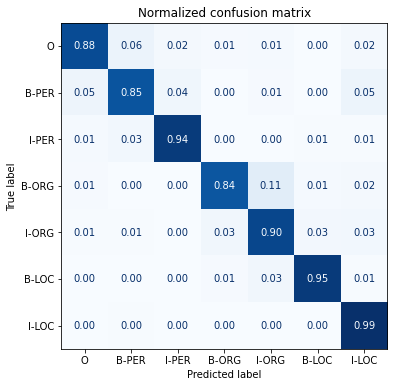

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

En el plot podemos ver que nuestro modelo tiende a confundir las entidades `B-ORG` y `I-ORG`. Es bastante bueno clasificando las otras entidades, lo cual es claro por la naturaleza casi diagonal de la matriz de confusion.

Ahora que ya vimos los errores a nivel token, podemos ver las secuencias con los losses mas altos. Primero vamos a definir una funcion para ayudarnos a ver las secuencias de tokens con sus etiquetas y losses:

In [54]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], [] 
        for i, mask in enumerate(row["attention_mask"]): 
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                                "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3) 

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,O,O,O,B-ORG,O,O,O,O,O,O,O
losses,0.00,0.00,3.51,0.00,0.00,0.00,10.16,9.82,6.32,7.92,7.95,0.00,8.78,8.48,0.00,9.15,8.60,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.83,0.00,0.00,7.77,9.06,8.74,5.66,0.00,7.14,8.05,5.31,4.30,4.42,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.29,5.42,6.10,0.00,5.92,0.00,5.84,0.00,5.38,5.44,5.72,5.61,5.47,5.25,0.00


Es aparente que hay algo malo con las etiquetas de estas muestras; por ejemplo United Nations y Central AFrican Republic son etiquetadas como personas. "8. Juli" esta etiquetado como organizacion. Resulta que algunas anotaciones del dataset PAN-X fueron generadas por un proceso automatizado. Estas anotaciones se conocen como "silver standard" (en contraste al "gold standard" de anotaciones generadas por humanos), y no es sorprendente que hay casos donde este approach automatizado falle; incluso los humanos hacen errores de anotacion.

Otra cosa que vimos antes fue que los parentesis y las barras tenian un loss alto. Veamos algunos ejemplos:

In [55]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2) 
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.03,0.00,0.06,0.04,0.05,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.00


En general, no incluiriamos los parentesis y sus contenidos como parte de un named entity, pero parece ser que es la forma en la que la extraccion automatica anoto los documentos. En otros ejemplos, los parentesis contienen especificacion geografica. Este dataset consiste de articulos de wikipedia en diferentes lenguajes, y los titulos de los articulos a veces contienen explicaciones en parentesis. Estos son detalles importantes que tenemos que saber cuando despleguemos nuestro modelo, ya que tienen implicaciones en el desmepenio del modelo y las tareas downstream del pipeline entero.

Con un analisis simple logramos identificar debilidades en nuestro modelo y el dataset. En un caso real hariamos varias iteraciones de esto, limpiando el dataset, reentrenando el modelo y analizando nuevos errores hasta estar satisfechos con el desempenio.

Aqui analizamos los errores en un solo lenguaje, pero tambien nos interesa ver los errores a traves de lenguajes. Ahora vamos a hace algunos experimentos para ver que tan bien funciona el cross-lingual transfer en XLM-R.

## Cross-Lingual Transfer

Como hicimos fine-tune del XLM-R en Aleman, podemos evaluar su habilidad de transferir a otros lenguajes usando el metodo `predict()` del `Trainer`. Hagamos una funcion para eso:

In [56]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

Podemos usar esta funcion para examinar el desempenio en el test set y llevar un registro de los scores en un `dict`:

In [57]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"]) 
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.869


Estos son resultados bastante buenos para una tarea NER. Nuestras metricas estan alrededor de 85%, y podemos ver que lo que mas le cuesta al modelo son las entidades `ORG`, probablemente porque son las menos comunes en el training set y muchas organizaciones tienen nombres que son raros en el vocabulario de `XLM-R`. Ahora veamos como le va en Frances:

In [58]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


Nada mal. Aunque el nombre y organizacion son lo mismo en ambos lenguajes, el modelo logro etiquetar correctamente la traduccion Frances de "Kalifornien". 

Ahora veamos como le va al modelo Aleman en el test set Frances entero. Escribamos una funcion que codifique el dataset y genere el reporte de clasificacion:

In [59]:
def evaluate_lang_performance(lang, trainer): 
    panx_ds = encode_panx_dataset(panx_ch[lang]) 
    return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer) 
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de] model on [fr] dataset: 0.702


Aunque vemos una caida de 15 puntos en las metricas promediadas, recuerden que nuestro modelo no ha visto ningun ejemplo en Frances. En general, la magnitud de la caida en el rendimiento esta relacionada a que "tan lejos" estan los lenguajes. Aunque el aleman y el frances se agrupan como lenguas indoeuropeas, tecnicamente pertenecen a diferentes familias linguisticas: germanica y romance, respectivamente.

Ahora evaluemos en Italiano. Como el Italiano tambien es un lenguaje romance, esperamos tener un resultado similar:

In [60]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer) 
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.674


Efectivamente lo podemos ver en el $F_1-score$. Finalmente, veamos en desempenio en ingles, que pertenece a la familia de lenguajes germanicos:

In [61]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer) 
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [en] dataset: 0.592


Sorprendentemente, al modelo le fue peor en ingles, aunque intuitivamente esperabamos que iba a ser mas similar al aleman que el frances.